In [66]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

plt.style.use('ggplot')

In [3]:
results = pd.read_csv("/Users/rob/proj/lt/gwgm/geowave-geomesa-comparative-analysis/analyze/gwgm-ca-run-results-Sept29.csv")

In [52]:
def get_cluster_results(clusterId):
    return results[results.clusterId == clusterId]

def remove_outiers(df):
    Q1 = df['duration'].quantile(0.25)
    Q3 = df['duration'].quantile(0.75)
    IQR = Q3 - Q1

    #Values between Q1-1.5IQR and Q3+1.5IQR
    return df.query('(@Q1 - 1.5 * @IQR) <= duration <= (@Q3 + 1.5 * @IQR)')

def get_qn(qn, df, r=True):
    q = df[df.queryName.str.contains(qn)]
    if r:
        return remove_outiers(q)
    else:
        return q

In [53]:
gm_default = get_cluster_results("j-2KONORTYS0CUG")
gw_default = get_cluster_results("j-16UW0FDHI16TV")
gm_match = get_cluster_results("j-3E3KPNGKVFRTK")
gw_match = get_cluster_results("j-HK05V75VYI20")

# gm = gm_default
# gw = gw_default

gm = gm_match
gw = gw_match
# gw_yearly_partitioned = getClusterResults(results.clusterId == "j-HK05V75VYI20"])
# gw_monthly = results[results.clusterId == "j-Q7HFJZY0XFJD"]
# gm_monthly = results[results.clusterId == "j-26TWWX470OI8U"]
# gw_yearly_partitioned = results[results.clusterId == "j-HK05V75VYI20"]
# gm_yearly = results[results.clusterId == "j-3E3KPNGKVFRTK"]

In [6]:
# gw.head(4)
get_qn("GDELT-IN-SOUTH-AMERICA-COUNTRIES-THREE-WEEKS", gw).count()

uuid                 6894
duration             6894
system               6894
timeAtFirstResult    6894
clusterId            6894
startTime            6894
endTime              6894
result               6894
queryName            6894
dtype: int64

In [38]:
pd.concat([get_qn(qn, gw_results), get_qn(qn, gm_results)]).to_csv(result_path(qn + ".csv"))

In [54]:
# Durations
gw_default_durations = gw_default[['queryName', "duration", "result"]].rename(columns = { "duration": "gw_default_duration"})
gw_default_durations["gw_default_ttfr"] = gw_default['timeAtFirstResult'] - gw_default['startTime']

gm_default_durations = gm_default[['queryName', "duration"]].rename(columns = { "duration": "gm_default_duration"})
gm_default_durations["gm_default_ttfr"] = gm_default['timeAtFirstResult'] - gm_default['startTime']

gw_match_durations = gw_match[['queryName', "duration"]].rename(columns = { "duration": "gw_match_duration"})
gw_match_durations["gw_match_ttfr"] = gw_match['timeAtFirstResult'] - gw_match['startTime']

gm_match_durations = gm_match[['queryName', "duration"]].rename(columns = { "duration": "gm_match_duration"})
gm_match_durations["gm_match_ttfr"] = gm_match['timeAtFirstResult'] - gm_match['startTime']

# gw_durations = gw_yearly_partitioned[['queryName', "duration"]].rename(columns = { "duration": "gw_yearly_partitioned_duration"})
# gw_durations["gw_yearly_partitioned_ttfr"] = gw_yearly_partitioned['timeAtFirstResult'] - gw_yearly_partitioned['startTime']

# gm_durations = gm_yearly[['queryName', "duration"]].rename(columns = { "duration": "gm_yearly_duration"})
# gm_durations["gm_yearly_ttfr"] = gm_yearly['timeAtFirstResult'] - gm_yearly['startTime']

# Time to first results
# gw_monthly_ttfr = gw_monthly[['queryName']].copy()
# gw_monthly_ttfr["gw_monthly_ttfr"] = gw_monthly['timeAtFirstResult'] - gw_monthly['startTime']

# gm_monthly_ttfr = gm_monthly[['queryName']].copy()
# gm_monthly_ttfr["gm_monthly_ttfr"] = gm_monthly['timeAtFirstResult'] - gm_monthly['startTime']

# gw_yearly_partitioned_ttfr = gw_yearly_partitioned[['queryName']].copy()
# gw_yearly_partitioned_ttfr["gw_yearly_partitioned_ttfr"] = gw_yearly_partitioned['timeAtFirstResult'] - gw_yearly_partitioned['startTime']

# gm_yearly_ttfr = gm_yearly[['queryName']].copy()
# gm_yearly_ttfr["gm_yearly_ttfr"] = gm_yearly['timeAtFirstResult'] - gm_yearly['startTime']

In [27]:
gw_match_durations.head(3)


,queryName,gw_match_duration,result,gw_match_ttfr
10,GDELT-IN-SOUTH-AMERICA-COUNTRIES-THREE-WEEKS-2...,141,1925,101
18,GDELT-IN-SOUTH-AMERICA-COUNTRIES-THREE-WEEKS-2...,67,100,63
22,GDELT-IN-CITY-BUFFERS-six-MONTHS-2013-Oslo-650-KM,479,17918,77


In [55]:
df_slices = [gw_default_durations.groupby("queryName").aggregate(np.mean).reset_index(),
             gm_default_durations.groupby("queryName").aggregate(np.mean).reset_index(),
             gw_match_durations.groupby("queryName").aggregate(np.mean).reset_index(),
             gm_match_durations.groupby("queryName").aggregate(np.mean).reset_index()]

# df_slices = [gw_durations.groupby("queryName").aggregate(np.mean).reset_index(),
#              gm_durations.groupby("queryName").aggregate(np.mean).reset_index()]

# print("EACH COUNT:")
# for df in df_slices:
#     print(df.count())
#     print(df["queryName"].unique().shape)
    
# print("Single merge count:")
# sm = pd.merge(df_slices[0].set_index("queryName"), df_slices[1].set_index("queryName"), on="queryName")
# print(sm.count())
# print(sm["queryName"].unique().shape)
    
combined = reduce(lambda x, y: pd.merge(x, y, on="queryName"), df_slices)
print("COMBINED COUNT")
print(combined.count())
# combined = combined[["queryName", "result", 
#                      "gw_monthly_duration", "gw_yearly_partitioned_duration",
#                      "gm_monthly_duration", "gm_yearly_duration",
#                      "gw_monthly_ttfr", "gw_yearly_partitioned_ttfr",
#                      "gm_monthly_ttfr", "gm_yearly_ttfr"]]
combined = combined[["queryName", "result", 
                     "gm_default_duration", "gw_default_duration",
                     "gm_match_duration", "gw_match_duration",
                     "gm_default_ttfr", "gw_default_ttfr",
                     "gm_match_ttfr", "gw_match_ttfr"]]

combined = combined[combined.queryName.str.contains("GDELT-IN-SOUTH-AMERICA-COUNTRIES-THREE-WEEKS")]


COMBINED COUNT
queryName              8092
gw_default_duration    8092
result                 8092
gw_default_ttfr        8092
gm_default_duration    8092
gm_default_ttfr        8092
gw_match_duration      8092
gw_match_ttfr          8092
gm_match_duration      8092
gm_match_ttfr          8092
dtype: int64


In [2]:
# combined.to_csv("/Users/rob/proj/lt/gwgm/geowave-geomesa-comparative-analysis/analyze/gwgm-ca-run-results-Sept27-duration_and_ttfr.csv")
combined= pd.read_csv("/Users/rob/proj/lt/gwgm/geowave-geomesa-comparative-analysis/analyze/gwgm-ca-run-results-Sept27-duration_and_ttfr.csv")

In [43]:
x = combined['queryName'].unique()[0]
x.split('-')



['GDELT',
 'IN',
 'SOUTH',
 'AMERICA',
 'COUNTRIES',
 'THREE',
 'WEEKS',
 '2000',
 'APR',
 'Argentina']

In [56]:
grouped = combined.groupby("queryName")
agg = grouped.aggregate(np.mean)
#agg.to_csv("/Users/rob/proj/lt/gwgm/geowave-geomesa-comparative-analysis/analyze/gwgm-ca-run-results-Sept27-agg-duration.csv")

In [57]:
# Labels the month
def label_month(row):
    return row.queryName.upper().split('-')[7]
  
combined['month'] = combined.apply(label_month, axis=1)    

In [58]:
# Labels the country
def label_country(row):
    return '-'.join(row.queryName.upper().split('-')[9:])

# combined.apply(label_size, axis=1).unique() 
combined['country'] = combined.apply(label_country, axis=1) 

In [59]:
# Labels the year
def label_year(row):
    try:
        int(row.queryName.upper().split('-')[7])
    except:
        print(row.queryName)
        raise     

# combined.apply(label_size, axis=1).unique() 
combined['year'] = combined.apply(label_year, axis=1) 

In [60]:
# Establish groups to bins
#for group in groups.values():
groups_to_ranges = { }
total_ranges = None

#grouped_by_result_quantiles = None
grouped_by_result_quantiles = combined.copy()

# # This does the quantiles per group
# for group in groups.values():
#     print(group)
#     df = combined[combined.group == group]
#     ranges = pd.qcut(df.result, 10)
#     groups_to_ranges[group] = ranges.unique()
#     df['range_group'] = pd.qcut(df.result, 10, labels=False)
#     #print(df.dtypes)
#     #print("OK")
#     if grouped_by_result_quantiles is None:
#         grouped_by_result_quantiles = df
#     else:
#         grouped_by_result_quantiles = grouped_by_result_quantiles.append(df)
   

total_ranges = pd.qcut(combined.result, 10,retbins=True)[1]
print(total_ranges)
#total_ranges = ranges.unique()
grouped_by_result_quantiles['range_group'] = pd.qcut(combined.result, 10, labels=False)


# df.head(3)
# bins = np.linspace(df.result.min(), df.result.max(), 10)

# def label_bin(row):
#     return np.digitize(row.result, bins)




[  0.00000000e+00   1.30000000e+01   7.02000000e+01   1.68300000e+02
   3.31400000e+02   5.40500000e+02   8.19600000e+02   1.35900000e+03
   2.43980000e+03   4.08790000e+03   2.06430000e+04]


In [ ]:
grouped_by_result_quantiles.to_csv("/Users/rob/proj/lt/gwgm/geowave-geomesa-comparative-analysis/analyze/gwgm-ca-run-results-Sept27-result-groups.csv")
# grouped_by_result_quantiles = pd.read_csv("/Users/rob/proj/lt/gwgm/geowave-geomesa-comparative-analysis/analyze/gwgm-ca-run-results-Sept27-result-groups.csv")

In [68]:
%matplotlib notebook

plt.style.use('ggplot')



In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('result')
ax.set_ylabel('duration (ms)')

mm = m[m.result < 10000]
wm = w[w.result < 10000]
mlm = ml[ml.result < 10000]

# sm = m
# sw = w
# sml = ml

sm = mm
sw = wm
sml = mlm

def do_scatter(loose=True):
    sm.plot.scatter(x="result", y="duration", ax=ax, color="red")
    if loose:
        sml.plot.scatter(x="result", y="duration", ax=ax, color="yellow")
    sw.plot.scatter(x="result", y="duration", ax=ax)


# mm[mm.result < 50000].plot.scatter(x="result", y="duration", ax=ax2, color="red")
# wm[wm.result < 50000].plot.scatter(x="result", y="duration", ax=ax2)

def do_regression(loose=True):
    mx = sm.result.values.reshape(-1,1)
    my = sm.duration.values.reshape(-1,1)

    regr = linear_model.LinearRegression()
    regr.fit(mx, my)

    plt.plot(mx, regr.predict(mx), color='orangered', linewidth=1)
    
    if loose:
        mlx = sml.result.values.reshape(-1,1)
        mly = sml.duration.values.reshape(-1,1)

        regr = linear_model.LinearRegression()
        regr.fit(mlx, mly)

        plt.plot(mlx, regr.predict(mlx), color='gold', linewidth=1)

    wx = sw.result.values.reshape(-1,1)
    wy = sw.duration.values.reshape(-1,1)

    regr = linear_model.LinearRegression()
    regr.fit(wx, wy)

    plt.plot(wx, regr.predict(wx), color='lightskyblue', linewidth=1)

# do_scatter(True)
do_regression(True)
# fig.set_figwidth(15)
plt.show()

save = True
# fname = "geolife-bbox-scatter-with-regression"
fname = "geolife-bbox-regression-with-loose-less-than-10000"
if save:
    path = "/Users/rob/proj/lt/gwgm/geowave-geomesa-comparative-analysis/analyze/pngset/%s.png" % fname
    fig.savefig(path, dpi=300, bbox_inches='tight')  


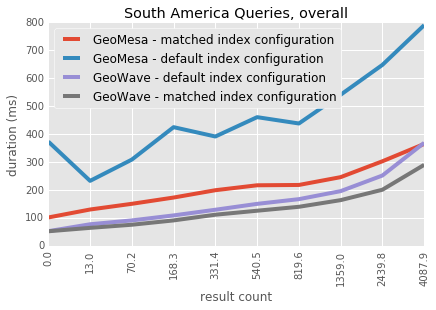

In [67]:
# only_matched = grouped_by_result_quantiles[["result", "group", "range_group",
#                     "gw_yearly_partitioned_duration",
#                     "gm_yearly_duration"]]

def plot_for_group(group, save=True):
    group_by_three = grouped_by_result_quantiles[grouped_by_result_quantiles.group == group].groupby(["range_group"])
    gbt_agg = group_by_three.aggregate(np.mean)
    # print(gbt_agg.dtypes)

    # ranges = groups_to_ranges[group]
    ranges = total_ranges
    xticks = list(map(str, list(ranges)))
    print(xticks)
    (size, days) = group_idxs[group]
    title = "City Buffer Queries, over 10 cities: %d km, %d days" % (size, days)
    
#     (fig, (ax, ax2)) = plt.subplots(nrows=2, sharey=False, sharex=True)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel('result count')
    ax.set_ylabel('duration (ms)')
    plot_columns = { "gw_yearly_partitioned_duration" : "GeoWave",
                     "gm_yearly_duration" : "GeoMesa" }
    gbt_agg[list(plot_columns.keys())].rename(columns = plot_columns).plot.line(ax = ax, title=title)
    
#     fig2 = plt.figure(2)
#     ax2 = fig2.add_subplot(111)
#     ax2.set_xlabel('result count')
#     ax2.set_ylabel('time to first result (ms)')  
#     plot_columns2 = { "gw_yearly_partitioned_ttfr": "GeoWave", "gm_yearly_ttfr": "GeoMesa"}
#     gbt_agg[list(plot_columns2.keys())].rename(columns = plot_columns2).plot.line(ax = ax2, legend = False)
    
    plt.xticks(range(0, 30), xticks, rotation='vertical')
    plt.show()
    if save:
        path = "/Users/rob/proj/lt/gwgm/geowave-geomesa-comparative-analysis/analyze/pngset/%03d-km-%03d-days.png" % (size, days)
        fig.savefig(path, dpi=300, bbox_inches='tight')
        

def plot_for_size(size, save=True):
    grouped_for_plot = grouped_by_result_quantiles[grouped_by_result_quantiles['size'] == size].groupby(["range_group"])
    gbt_agg = grouped_for_plot.aggregate(np.mean)
    # print(gbt_agg.dtypes)

    # ranges = groups_to_ranges[group]
    ranges = total_ranges
    xticks = list(map(str, list(ranges)))
    # print(xticks)
    title = "City Buffer Queries, over 10 cities: %d KM" % size
    
#     (fig, (ax, ax2)) = plt.subplots(nrows=2, sharey=False, sharex=True)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel('result count')
    ax.set_ylabel('duration (ms)')
    plot_columns = { "gw_yearly_partitioned_duration" : "GeoWave",
                     "gm_yearly_duration" : "GeoMesa" }
    gbt_agg[list(plot_columns.keys())].rename(columns = plot_columns).plot.line(ax = ax, title=title)
    
#     fig2 = plt.figure(2)
#     ax2 = fig2.add_subplot(111)
    # ax.set_xlabel('result count')
#     ax2.set_ylabel('time to first result (ms)')  
#     plot_columns2 = { "gw_yearly_partitioned_ttfr": "GeoWave", "gm_yearly_ttfr": "GeoMesa"}
#     gbt_agg[list(plot_columns2.keys())].rename(columns = plot_columns2).plot.line(ax = ax2, legend = False)
    
    plt.xticks(range(0, 30), xticks, rotation='vertical')
    
    plt.show()
    if save:
        path = "/Users/rob/proj/lt/gwgm/geowave-geomesa-comparative-analysis/analyze/pngset/%03d-km.png" % size
        fig.savefig(path, dpi=300, bbox_inches='tight')
        
def plot_agg(grouped_agg,
             title,
             fname,
             include_default=True,
             include_match=True,
             range_cap=None,
             save=True):
    ranges = total_ranges
    xticks = list(map(str, list(ranges)))
    
#     (fig, (ax, ax2)) = plt.subplots(nrows=2, sharey=False, sharex=True)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel('result count')
    ax.set_ylabel('duration (ms)')
    plot_columns = { }
    if include_default and include_match:
        plot_columns["gw_default_duration"] = "GeoWave - default index configuration"
        plot_columns["gm_default_duration"] = "GeoMesa - default index configuration"
        plot_columns["gw_match_duration"] = "GeoWave - matched index configuration"
        plot_columns["gm_match_duration"] = "GeoMesa - matched index configuration"
    elif include_match:
        plot_columns["gw_match_duration"] = "GeoWave"
        plot_columns["gm_match_duration"] = "GeoMesa"
    else:
        plot_columns["gw_default_duration"] = "GeoWave"
        plot_columns["gm_default_duration"] = "GeoMesa"

    grouped_agg[list(plot_columns.keys())].rename(columns = plot_columns).plot.line(ax = ax, title=title)
    
#     fig2 = plt.figure(2)
#     ax2 = fig2.add_subplot(111)
    # ax.set_xlabel('result count')
#     ax2.set_ylabel('time to first result (ms)')  
#     plot_columns2 = { "gw_yearly_partitioned_ttfr": "GeoWave", "gm_yearly_ttfr": "GeoMesa"}
#     gbt_agg[list(plot_columns2.keys())].rename(columns = plot_columns2).plot.line(ax = ax2, legend = False)

    if not range_cap:
        range_cap = 10
    plt.xticks(range(0, range_cap), xticks, rotation='vertical')
    plt.xlabel("result count")
    plt.show()
    if save:
        path = "/Users/rob/proj/lt/gwgm/geowave-geomesa-comparative-analysis/analyze/pngset/%s.png" % fname
        fig.savefig(path, dpi=300, bbox_inches='tight')  
        
def agg_for_time(days, range_cap = None):
    df = grouped_by_result_quantiles[grouped_by_result_quantiles.days == days]
    if range_cap:
        df = df[df.range_group < range_cap]
    grouped_for_plot = df.groupby(["range_group"])
    
    return grouped_for_plot.aggregate(np.mean)


def agg_for_all(range_cap = None):
    df = grouped_by_result_quantiles
    if range_cap:
        df = df[df.range_group < range_cap]
    grouped_for_plot = df.groupby(["range_group"])
    
    return grouped_for_plot.aggregate(np.mean)  
     

# plot_for_group(1, save=False)
# for group in groups.values():
#     plot_for_group(group)

# plot_for_time(56, save=False)
# for days in set(map(lambda x: x[1], groups.keys())):
#     range_cap = None
#     # print("Plotting for %d" % days)
#     time_agg = agg_for_time(days, range_cap = range_cap)
#     plot_agg(time_agg, 
#              "South America Queries: %d days" % days,
#              "%03d-days-default" % days,
#              include_default = True,
#              include_match = False,
#              range_cap = range_cap,
#              save = True)

range_cap = None
overall_agg = agg_for_all(range_cap = range_cap)
plot_agg(overall_agg, 
         "South America Queries, overall",
         "sa-overall-duration-vs-result-both",
         include_default = True,
         include_match = True,
         range_cap = range_cap,
         save = False)

# plot_for_size(550, save=False)
# print(set(map(lambda x: x[0], groups.keys())))
# for size in set(map(lambda x: x[0], groups.keys())):
#     # print("Plotting for %d" % days)
#     plot_for_size(size)
